In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/CS 498 Intro to DL/Project")
os.getcwd()

Mounted at /content/gdrive


'/content/gdrive/My Drive/CS 498 Intro to DL/Project'

In [2]:
import time
import torch
import torch.nn as nn
from torchvision import models,transforms
import torch.nn.functional as F
from utils import ConvLSTM
import operator
from model import SegNet_ConvLSTM
from dataset import  RoadSequenceDatasetList
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,f1_score

In [ ]:
torch.randn(2,3,4)

tensor([[[-1.0366,  0.3598,  1.3451,  1.2970],
         [ 0.4511,  0.0868,  1.1517,  0.6947],
         [ 1.0758,  1.3765, -0.8024,  0.2281]],

        [[ 0.6200,  0.6712, -1.9149, -1.1313],
         [ 0.4540, -0.4287, -0.7205, -0.9438],
         [-0.5276,  0.9963,  0.9809,  0.5008]]])

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
batch_size=4
train_path='/content/gdrive/My Drive/CS 498 Intro to DL/Project/Dataset/Dataset'
epochs=50

train_transforms = transforms.Compose([
                                       transforms.RandomHorizontalFlip(p=1),
                                       transforms.ToTensor()
                                       ])

In [5]:
target = None
def train(epoch, model, train_loader, device, optimizer, criterion, val_loader,best_acc):
    log_interval=20
    since = time.time()
    model.train()
    #best_acc = 0
    for batch_idx,  sample_batched in enumerate(train_loader):
        #print("epoch is ", epoch)
        #print("batch is ", batch_idx)
        
        data, target = sample_batched['data'].to(device), sample_batched['label'].type(torch.LongTensor).to(device) # LongTensor
        optimizer.zero_grad()
        output = model(data)
        #print("target size is",target.size())
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        #print("Here")
        if batch_idx % log_interval == 0:
            print("epoch is ", epoch)
            print("batch is ", batch_idx)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
    time_elapsed = time.time() - since
    print('Train Epoch: {} complete in {:.0f}m {:.0f}s'.format(epoch,
        time_elapsed // 60, time_elapsed % 60))


In [6]:
dummy_pred = torch.zeros((4,1,128,256))
dummy_gt = torch.zeros((4,1,128,256))

def val( model, val_loader, device, criterion, best_acc):
    model.eval()
    test_loss = 0
    correct = 0
    test_batch_size=batch_size
 
    cnf_mat = 0
    f1 = 0
    count =0
    with torch.no_grad():
        for sample_batched in val_loader:
            data, target = sample_batched['data'].to(device), sample_batched['label'].type(torch.LongTensor).to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            cnf_mat += confusion_matrix(target.view_as(pred).view(-1).to('cpu').numpy(), pred.view(-1).to('cpu').numpy())
            f1 += f1_score(target.view_as(pred).view(-1).to('cpu').numpy(), pred.view(-1).to('cpu').numpy(),average='binary')
            count = count+1  
            
    test_loss /= (len(val_loader.dataset)/test_batch_size)
    val_acc = 100. * int(correct) / (len(val_loader.dataset) * 128 * 256)
    avg_f1_score = f1/count
    avg_cnf_mat = cnf_mat/count

    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)\n'.format(
        test_loss, int(correct), len(val_loader.dataset), val_acc))
    torch.save(model.state_dict(), 'SGD_.001_cross_entropy_last_10_sequence_%s.pth'%val_acc)
    print("Confusion Matrix is ",avg_cnf_mat)
    print("F1 score is",avg_f1_score)

In [7]:
train_loader=torch.utils.data.DataLoader(
            RoadSequenceDatasetList(file_path=train_path,transforms_1=transforms.ToTensor(),flag='train'),
            batch_size=batch_size, shuffle=True, num_workers=4)

epsilon_


In [8]:
val_loader=torch.utils.data.DataLoader(
            RoadSequenceDatasetList(file_path=train_path,transforms_1=transforms.ToTensor(),flag='test'),
            batch_size=batch_size, shuffle=True, num_workers=4)

epsilon_


In [9]:
model = SegNet_ConvLSTM().to('cuda:0')

optimizer = torch.optim.Adam(model.parameters(), lr=.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
#class_weight = [0.02, 1.02]
class_weight = [0.4, 1]
class_weight = torch.Tensor(class_weight).to('cuda:0')
criterion = torch.nn.CrossEntropyLoss(weight=class_weight).to(device)


best_acc = 0

#pretrained_path = "SGD_.001_cross_entropy_last_10_sequence_87.04843447189923.pth"
#pretrained_path = "Transforms_cross_entropy_last_10_sequence_78.04815518367595.pth"
#pretrained_path = "cross_entropy_last_10_sequence_89.04957987805406.pth"
#pretrained_path = "cross_entropy_alternate_sequence_89.02732198552567.pth"
pretrained_path = "adams_weights_1_04.pth"
#pretrained_path = "adam_vertical_flip.pth"
pretrained_dict = torch.load(pretrained_path)
model_dict = model.state_dict()

pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if (k in model_dict)}
model_dict.update(pretrained_dict_1)
model.load_state_dict(model_dict)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


<All keys matched successfully>

In [ ]:
# train

for epoch in range(1, epochs+1):
    #scheduler.step()
    train(epoch, model, train_loader, device, optimizer, criterion, val_loader,best_acc)
    val(model, val_loader, device, criterion, best_acc) 
    scheduler.step() 

Streaming output truncated to the last 5000 lines.
batch is  260
Train Epoch: 6 [1040/2723 (38%)]	Loss: 0.078020
epoch is  6
batch is  280
Train Epoch: 6 [1120/2723 (41%)]	Loss: 0.080171
epoch is  6
batch is  300
Train Epoch: 6 [1200/2723 (44%)]	Loss: 0.085108
epoch is  6
batch is  320
Train Epoch: 6 [1280/2723 (47%)]	Loss: 0.065622
epoch is  6
batch is  340
Train Epoch: 6 [1360/2723 (50%)]	Loss: 0.082857
epoch is  6
batch is  360
Train Epoch: 6 [1440/2723 (53%)]	Loss: 0.097909
epoch is  6
batch is  380
Train Epoch: 6 [1520/2723 (56%)]	Loss: 0.081485
epoch is  6
batch is  400
Train Epoch: 6 [1600/2723 (59%)]	Loss: 0.082635
epoch is  6
batch is  420
Train Epoch: 6 [1680/2723 (62%)]	Loss: 0.071782
epoch is  6
batch is  440
Train Epoch: 6 [1760/2723 (65%)]	Loss: 0.087716
epoch is  6
batch is  460
Train Epoch: 6 [1840/2723 (68%)]	Loss: 0.069872
epoch is  6
batch is  480
Train Epoch: 6 [1920/2723 (70%)]	Loss: 0.091718
epoch is  6
batch is  500
Train Epoch: 6 [2000/2723 (73%)]	Loss: 0.094874

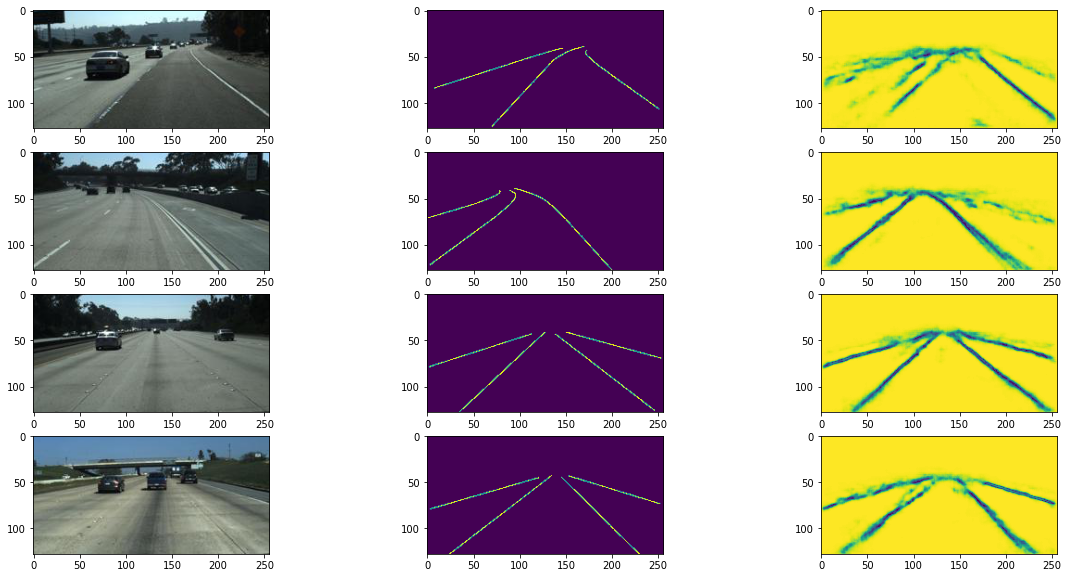

In [11]:
#Print Predictions
model.eval()
with torch.no_grad():

  for sample_batched in val_loader:
    data, target = sample_batched['data'].to(device), sample_batched['label'].type(torch.LongTensor).to(device)
    output = model(data)
    break

#convert output,target,data to list

fig = plt.figure(figsize=(20,10))
col = 3
row = batch_size
count = 1
for i,j,k in zip(output,target,data):
  #Image
  fig.add_subplot(row,col,count)
  plt.imshow(k[1].permute(1,2,0).cpu())
  

  #GroundTruth
  fig.add_subplot(row,col,count+1)
  plt.imshow(j.cpu())
  

  #Prediction 
  fig.add_subplot(row,col,count+2)
  #plt.imshow(i)
  plt.imshow(torch.max(i.permute(1,2,0),2)[0].cpu())

  count = count+3

plt.show()  


#problem:- Whenever vehicles are coming in view, prediction is not good. solved
#problem:- Currently learning is staurating at 86.6% accuracy, tried horizontal flip should have tried vertical tried
#try regularization, looks like overfitting happening
#try reducing weights too try [1,.4] ###worked
#try changing learning rate decay. I think it is stucking to local minima because of very small learning rate
#add gaussian noise to input data for diverity with deviation .02%
#another problem is lanes are not able to take turn, overfitting because of less curvy data, but we can add extra network which predicts centre of road and groun
#truth would be mean position row wise and some how using that loss to update netwrok wit the loss we are already using. 